In [86]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [34]:
df = pd.read_csv('data/Combined_Less.csv', low_memory = False)

In [35]:
df_filtered = df.dropna(subset=['TotCount'])
df_filtered.head()

,species,state,HUCName,Common_Name,Dataset,Station_Date,SITE_ID,YEAR,month,ECOREGL3,...,num,mg,na,k,hco3,tn,al,Se,Cadmium,Calcium
0,Ambloplites rupestris,OH,NaN,Rock Bass,OH,200282_38909,200282,2006,8,70,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Campostoma anomalum,OH,NaN,Central Stoneroller,OH,200282_38909,200282,2006,8,70,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Catostomus commersonii,OH,NaN,White Sucker,OH,200282_38909,200282,2006,8,70,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Chrosomus erythrogaster,OH,NaN,South. Redbelly Dace,OH,200282_38909,200282,2006,8,70,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Clinostomus funduloides,OH,NaN,Rosyside Dace,OH,200282_38909,200282,2006,8,70,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
common_name_counts = df_filtered['Common_Name'].value_counts()
tot_count_per_name = df_filtered.groupby('Common_Name')['TotCount'].sum()
for common_name in common_name_counts.index:
    count = common_name_counts[common_name]
    tot_count = tot_count_per_name[common_name]
    #print(f"{common_name}: {count} rows, Total TotCount: {tot_count}")

In [37]:
selected_fish = 'Bluntnose Minnow'
fish_df = df_filtered[df_filtered['Common_Name'] == selected_fish].copy()
fish_df.head()

,species,state,HUCName,Common_Name,Dataset,Station_Date,SITE_ID,YEAR,month,ECOREGL3,...,num,mg,na,k,hco3,tn,al,Se,Cadmium,Calcium
14,Pimephales notatus,OH,NaN,Bluntnose Minnow,OH,200282_38909,200282,2006,8,70,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,Pimephales notatus,OH,NaN,Bluntnose Minnow,OH,200296_38929,200296,2006,8,70,...,1.0,1110.879792,543.720098,76.729659,983.332192,375.0,NaN,NaN,NaN,NaN
49,Pimephales notatus,OH,NaN,Bluntnose Minnow,OH,200299_38929,200299,2006,8,70,...,1.0,1398.885664,1000.444981,102.306212,1343.887328,1155.0,NaN,NaN,NaN,NaN
85,Pimephales notatus,OH,NaN,Bluntnose Minnow,OH,200309_38924,200309,2006,9,70,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107,Pimephales notatus,OH,NaN,Bluntnose Minnow,OH,200313_38916,200313,2006,9,70,...,1.0,2756.627632,456.724882,76.729659,4121.800770,260.0,NaN,NaN,NaN,NaN


In [38]:
constant_columns = [col for col in fish_df.columns if fish_df[col].nunique() <= 1]
print("Constant Columns:", constant_columns)

Constant Columns: ['species', 'state', 'Common_Name', 'Dataset', 'ECOREGL3', 'BigHUC', 'FE', 'MN', 'TP', 'do', 'Temp', 'GENUS', 'NUMSPEC', 'NSBENT_INV', 'NSBENT_INV_NONTOL', 'NSINTOL', 'PINTOL', 'PBENT_INV', 'PBENT_INV_NONTOL', 'abent_inv', 'abent_inv_nontol', 'aintol', 'ns_DarScuMad', 'ab_DarScuMad', 'p_DarScuMad', 'FOR_TOT', 'hardness', 'Fecal_Coliform', 'xembed', 'pct_safn', 'al', 'Se', 'Cadmium', 'Calcium']


In [39]:
fish_df = fish_df.drop(columns=constant_columns)
fish_df = fish_df.drop(columns=['SUMCOUNT'])
numerical_df = fish_df.select_dtypes(include=[np.number])

In [52]:
null_percentage = numerical_df.isnull().mean() * 100
for column, percentage in null_percentage.items():
    print(f"{column}: {percentage:.2f}%")

YEAR: 0.00%
month: 0.00%
LAT_DD: 0.00%
LON_DD: 0.00%
HUC: 0.00%
PHSTVL: 0.00%
COND: 0.00%
CA: 4.25%
SO4: 11.02%
NO3: 4.09%
CL: 4.09%
alk: 11.18%
rbpscore: 55.75%
ABUND: 0.00%
WS_AREA: 0.00%
LWSKM2: 0.00%
lcond: 0.00%
SO4HCO3: 11.18%
ratio: 11.18%
TotCount: 0.00%
RA: 0.00%
VISIT_NO: 0.00%
num: 0.00%
mg: 4.88%
na: 4.25%
k: 4.25%
hco3: 11.18%
tn: 4.09%


In [53]:
numerical_df = numerical_df.drop(columns = ['rbpscore'])

In [54]:
outlier_info = {}
for column in numerical_df.select_dtypes(include=[np.number]).columns:
    Q1 = numerical_df[column].quantile(0.25)
    Q3 = numerical_df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = numerical_df[(numerical_df[column] < lower_bound) | (numerical_df[column] > upper_bound)][column]
    outlier_percentage = (len(outliers) / len(df)) * 100
    outlier_info[column] = outlier_percentage


In [55]:
for column in numerical_df.columns:
    if column in outlier_info:
        print(f"{column}: Null Percentage = {null_percentage[column]:.2f}%, Outlier Percentage = {outlier_info[column]:.2f}%")
    else:
        print(f"{column}: Null Percentage = {null_percentage[column]:.2f}%")

YEAR: Null Percentage = 0.00%, Outlier Percentage = 0.04%
month: Null Percentage = 0.00%, Outlier Percentage = 0.13%
LAT_DD: Null Percentage = 0.00%, Outlier Percentage = 0.00%
LON_DD: Null Percentage = 0.00%, Outlier Percentage = 0.00%
HUC: Null Percentage = 0.00%, Outlier Percentage = 0.00%
PHSTVL: Null Percentage = 0.00%, Outlier Percentage = 0.03%
COND: Null Percentage = 0.00%, Outlier Percentage = 0.12%
CA: Null Percentage = 4.25%, Outlier Percentage = 0.10%
SO4: Null Percentage = 11.02%, Outlier Percentage = 0.14%
NO3: Null Percentage = 4.09%, Outlier Percentage = 0.14%
CL: Null Percentage = 4.09%, Outlier Percentage = 0.10%
alk: Null Percentage = 11.18%, Outlier Percentage = 0.00%
ABUND: Null Percentage = 0.00%, Outlier Percentage = 0.12%
WS_AREA: Null Percentage = 0.00%, Outlier Percentage = 0.21%
LWSKM2: Null Percentage = 0.00%, Outlier Percentage = 0.02%
lcond: Null Percentage = 0.00%, Outlier Percentage = 0.02%
SO4HCO3: Null Percentage = 11.18%, Outlier Percentage = 0.12%
ra

In [56]:
numerical_df = numerical_df.fillna(numerical_df.mean())

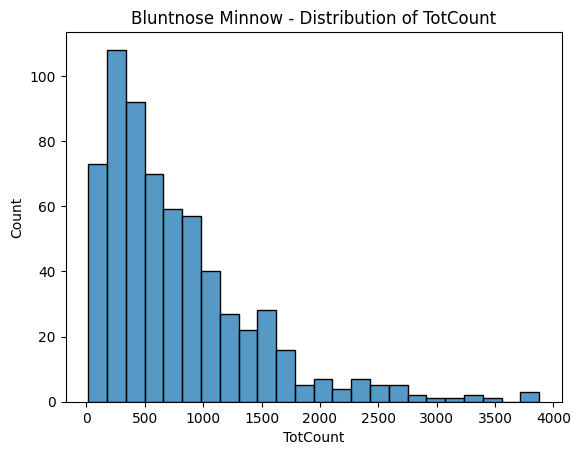

In [57]:
sns.histplot(numerical_df['TotCount'])
plt.title(f'{selected_fish} - Distribution of TotCount')
plt.show()

In [58]:
correlation_matrix = numerical_df.corr()

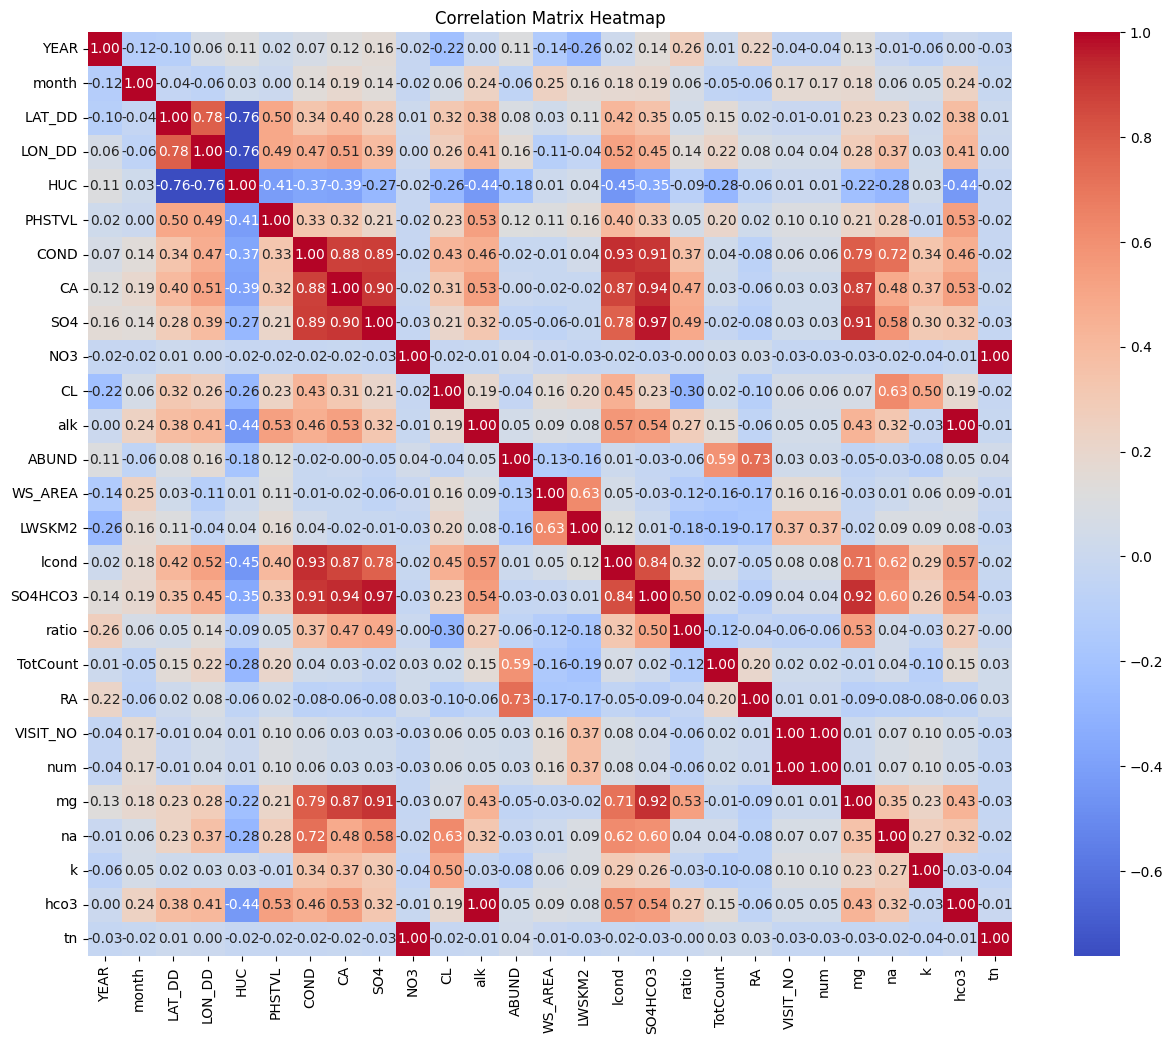

In [59]:
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [60]:
totcount_corr = correlation_matrix['TotCount'].sort_values(ascending=False)

In [61]:
X = numerical_df.drop(columns=['TotCount'])
y = numerical_df['TotCount']

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [64]:
model = LinearRegression()

In [65]:
model.fit(X_train_scaled, y_train)

LinearRegression()

In [66]:
y_pred = model.predict(X_test_scaled)

In [67]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)


Mean Squared Error: 173353.64969958414
R-squared: 0.5158558849104777


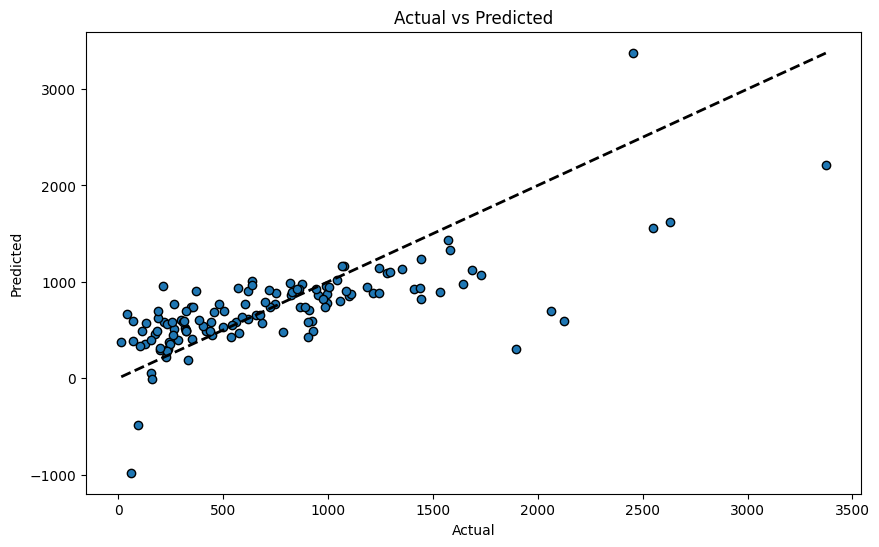

In [68]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

In [71]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

In [73]:
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

In [74]:
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

In [75]:
print("Random Forest Mean Squared Error:", mse_rf)
print("Random Forest R-squared:", r2_rf)

Random Forest Mean Squared Error: 64826.18631102363
Random Forest R-squared: 0.8189526631797569


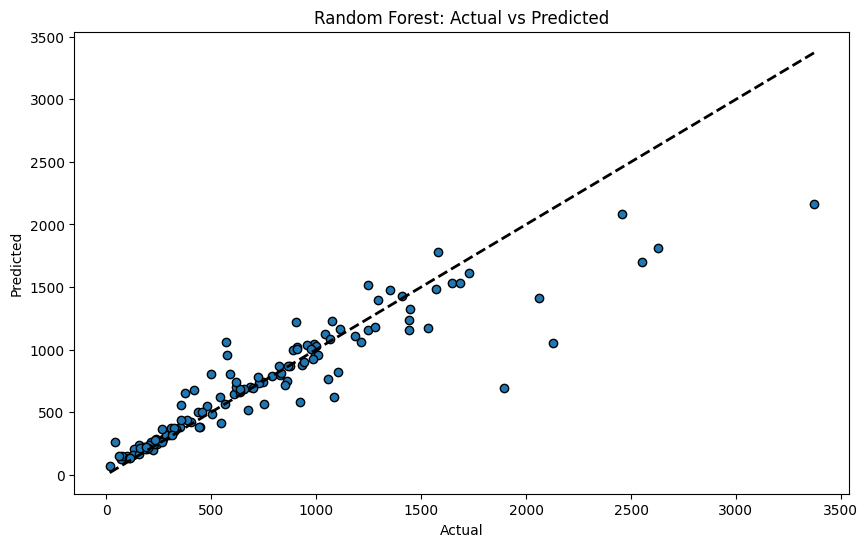

In [76]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, edgecolors=(0, 0, 0))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest: Actual vs Predicted')
plt.show()

In [77]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

In [78]:
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. feature {feature_names[indices[f]]} ({importances[indices[f]]})")

Feature ranking:
1. feature ABUND (0.5495353532313985)
2. feature RA (0.3286043582598386)
3. feature LON_DD (0.02521827103649903)
4. feature tn (0.009255315507052466)
5. feature PHSTVL (0.0075031813234052004)
6. feature mg (0.007439767043447269)
7. feature na (0.006150129540392852)
8. feature ratio (0.005769000774775649)
9. feature NO3 (0.005694771706996408)
10. feature CL (0.005285303210121854)
11. feature COND (0.004815907369365281)
12. feature LAT_DD (0.004277433123253201)
13. feature alk (0.00422999240829581)
14. feature SO4 (0.004200839997346658)
15. feature CA (0.004113654393149524)
16. feature lcond (0.004072713392196518)
17. feature month (0.004060706384281446)
18. feature hco3 (0.0038374246289290077)
19. feature WS_AREA (0.0036765896247413477)
20. feature k (0.0029649978857706656)
21. feature LWSKM2 (0.002831981952345251)
22. feature SO4HCO3 (0.00265408363500975)
23. feature YEAR (0.0023407229449707192)
24. feature HUC (0.0006331560290229315)
25. feature num (0.000465682658478

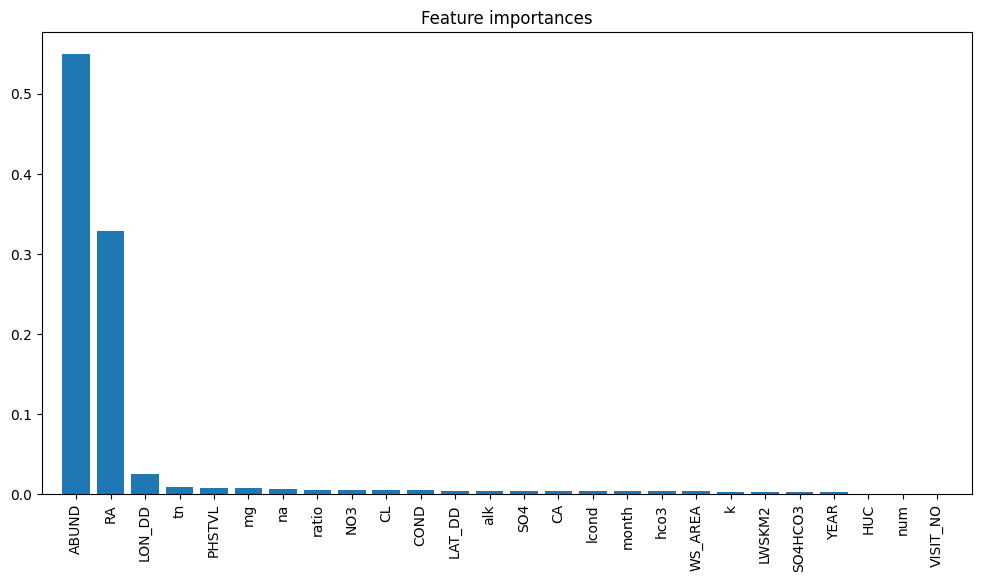

In [79]:
plt.figure(figsize=(12, 6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

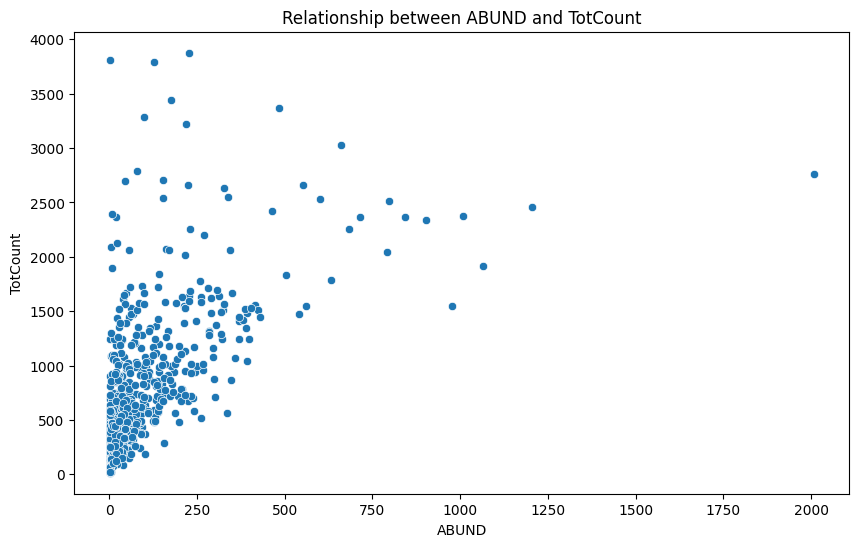

In [80]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=fish_df['ABUND'], y=fish_df['TotCount'])
plt.xlabel('ABUND')
plt.ylabel('TotCount')
plt.title('Relationship between ABUND and TotCount')
plt.show()

In [81]:
X_no_abund = numerical_df.drop(columns=['TotCount', 'ABUND'])
y = numerical_df['TotCount']
X_train_no_abund, X_test_no_abund, y_train_no_abund, y_test_no_abund = train_test_split(X_no_abund, y, test_size=0.2, random_state=42)
X_train_no_abund_scaled = scaler.fit_transform(X_train_no_abund)
X_test_no_abund_scaled = scaler.transform(X_test_no_abund)

In [82]:
rf_model_no_abund = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_no_abund.fit(X_train_no_abund_scaled, y_train_no_abund)

RandomForestRegressor(random_state=42)

In [83]:
y_pred_rf_no_abund = rf_model_no_abund.predict(X_test_no_abund_scaled)

In [84]:
mse_rf_no_abund = mean_squared_error(y_test_no_abund, y_pred_rf_no_abund)
r2_rf_no_abund = r2_score(y_test_no_abund, y_pred_rf_no_abund)

print("Random Forest without ABUND Mean Squared Error:", mse_rf_no_abund)
print("Random Forest without ABUND R-squared:", r2_rf_no_abund)

Random Forest without ABUND Mean Squared Error: 276717.9874173228
Random Forest without ABUND R-squared: 0.22717874483934397


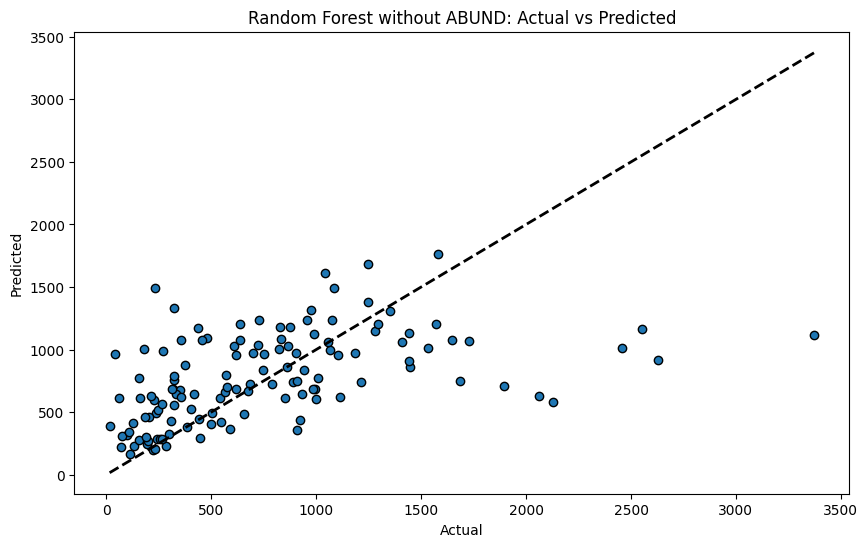

In [85]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_no_abund, y_pred_rf_no_abund, edgecolors=(0, 0, 0))
plt.plot([y_test_no_abund.min(), y_test_no_abund.max()], [y_test_no_abund.min(), y_test_no_abund.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest without ABUND: Actual vs Predicted')
plt.show()

In [87]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_no_abund)

In [88]:
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y, test_size=0.2, random_state=42)
scaler_poly = StandardScaler()
X_train_poly_scaled = scaler_poly.fit_transform(X_train_poly)
X_test_poly_scaled = scaler_poly.transform(X_test_poly)

In [89]:
rf_model_poly = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_poly.fit(X_train_poly_scaled, y_train_poly)

RandomForestRegressor(random_state=42)

In [90]:
y_pred_rf_poly = rf_model_poly.predict(X_test_poly_scaled)

In [91]:
mse_rf_poly = mean_squared_error(y_test_poly, y_pred_rf_poly)
r2_rf_poly = r2_score(y_test_poly, y_pred_rf_poly)
print("Random Forest with Polynomial Features Mean Squared Error:", mse_rf_poly)
print("Random Forest with Polynomial Features R-squared:", r2_rf_poly)

Random Forest with Polynomial Features Mean Squared Error: 277821.8787433071
Random Forest with Polynomial Features R-squared: 0.22409578413964237


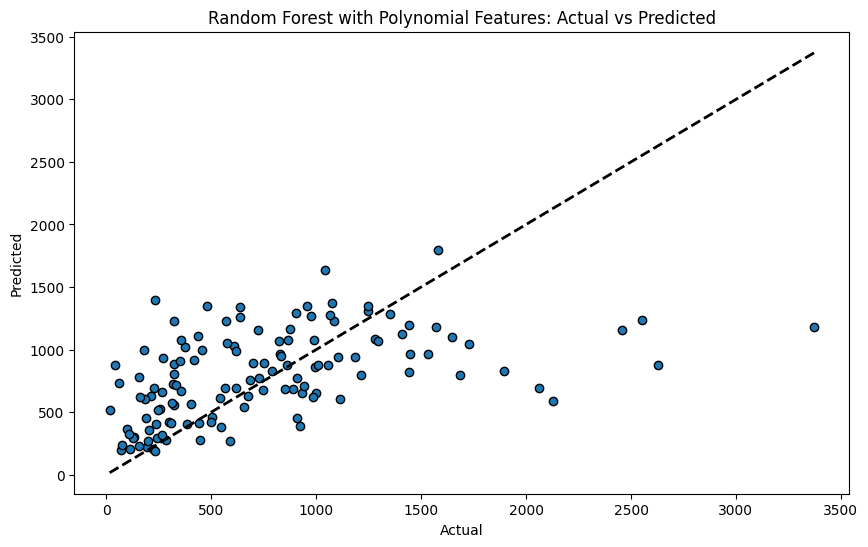

In [92]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_poly, y_pred_rf_poly, edgecolors=(0, 0, 0))
plt.plot([y_test_poly.min(), y_test_poly.max()], [y_test_poly.min(), y_test_poly.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest with Polynomial Features: Actual vs Predicted')
plt.show()

Try making new columns holding the number of predatory fish per Site/Year ID. Maybe they have a greater impact on the prey fish than other variables?